<a href="https://colab.research.google.com/github/dingyida/reinforce-learning/blob/main/11.6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# HalfCheetah: Learn a Dynamics Model from Random Rollouts (Then Validate It)

**Goal:** In this notebook you'll (1) collect random experience tuples \((s_t, a_t, r_t, s_{t+1})\) from `HalfCheetah-v4`, (2) train a neural network to predict **state deltas** \(\Delta s = s_{t+1}-s_t\), and (3) **validate** the model with one-step and multi-step (open-loop) rollouts.

This mirrors the first phase of model-based control (e.g., MPPI): learn a model offline, then use it for planning.



## 0. Requirements

- Python 3.9+
- PyTorch `>= 1.10`
- Gymnasium `>= 0.29`
- MuJoCo with `HalfCheetah-v4` (install `mujoco` and `gymnasium[mujoco]`)

```bash
pip install "gymnasium[mujoco]" mujoco torch matplotlib
```

**Try and understand what RunningNormalizer does.**


In [ ]:

import os, math, random, time
from dataclasses import dataclass
from typing import Tuple
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym

def to_t(x):
    return th.as_tensor(x, dtype=th.float32)

def fanin_init(m):
    if isinstance(m, nn.Linear):
        bound = 1.0 / math.sqrt(m.weight.size(1))
        nn.init.uniform_(m.weight, -bound, +bound)
        nn.init.zeros_(m.bias)

class RunningNormalizer:
    """Feature-wise running mean/std (Welford)."""
    def __init__(self, dim, eps=1e-8):
        self.dim = dim
        self.count = 0
        self.mean = np.zeros(dim, dtype=np.float64)
        self.M2   = np.zeros(dim, dtype=np.float64)
        self.eps  = eps

    def update(self, x: np.ndarray):
        x = np.asarray(x)
        if x.ndim == 1: x = x[None, :]
        for v in x:
            self.count += 1
            d = v - self.mean
            self.mean += d / self.count
            d2 = v - self.mean
            self.M2 += d * d2

    @property
    def var(self):
        if self.count < 2: return np.ones(self.dim, dtype=np.float64)
        return self.M2 / (self.count - 1 + 1e-12)

    @property
    def std(self):
        return np.sqrt(self.var + self.eps)

    def normalize(self, x): return (x - self.mean) / self.std
    def denormalize(self, x): return x * self.std + self.mean

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); th.manual_seed(seed)



## Initializing Environment and Figure Out Observation Structure

`HalfCheetah-v4` exposes observations as `[qpos[1:], qvel[:]]`. The forward velocity is `qvel[0]`, which sits at index `len(qpos[1:])` inside the observation vector. We'll extract that index for later validation/plots. :::: This is important for planning, if we want to know what each state represents


In [ ]:

set_seed(42)
env = gym.make("HalfCheetah-v4")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
act_low = env.action_space.low
act_high = env.action_space.high

# Find start index of qvel inside obs = [qpos[1:], qvel[:]]
nq = env.unwrapped.model.nq
qvel_start = int(nq - 1)
print("obs_dim:", obs_dim, "act_dim:", act_dim, "qvel_start:", qvel_start)


obs_dim: 17 act_dim: 6 qvel_start: 8


## 🧩 Task 1: Prepare the Replay Buffer
**Goal:** Store transitions \((s_t, a_t, s_{t+1})\) and return training pairs \((x, y) = (s_t, a_t, s_{t+1} - s_t)\).

**Instructions:**
- Implement `add()` to record transitions.
- Add a `sample()` method to randomly sample batch of certain size.



In [ ]:
# Create the class and create a class object
class Replay:
    def __init__(self, obs_dim, act_dim, capacity=300000):
        self.obs = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.act = np.zeros((capacity, act_dim), dtype=np.float32)
        self.nxt = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.rew = np.zeros((capacity, 1), dtype=np.float32)
        self.term = np.zeros((capacity, 1), dtype=np.float32)
        self.ptr = 0; self.size = 0; self.cap = capacity

    def add(self, s, a, r, sp, term):
        pass

    def sample(self, batch):
        pass

replay = Replay(obs_dim, act_dim)



## Task 2. Collect Random Rollouts

- Gather random actions for a number of steps to create our training dataset. Collect data for 100000 steps.
- Call the function and fill the replay buffer


In [ ]:

def collect_random(env, replay, steps=10000, seed=42):
    pass




## Task 3. Update normalizers from the collected random data in the replay buffer

We normalize inputs (`[s,a]`) and targets (`Δs = s' - s`) for stable training.


In [ ]:

obs_norm = RunningNormalizer(obs_dim)
inp_norm = RunningNormalizer(obs_dim + act_dim)
targ_norm = RunningNormalizer(obs_dim)

# write the function to update the normalizers from the data collected in the buffer
def update_normalizers_from_buffer(replay):
    pass

update_normalizers_from_buffer(replay)
print("Normalizers ready.")


Normalizers ready.



## Defining the Neural Dynamics Model

We predict **normalized** `Δs` from **normalized** `[s, a]`.
NN parameters:

- initialize a deterministic NN with a ExponentialLR sceduler( that decays the learning rate with epoch)
- width = 200, depth = 3, lr = 1e-3, weight_decay - 1e-5, gamma for scheduler = 0.8
- These are a starting point but not the best parameters.


In [ ]:

class DetMLP(nn.Module):
    """Predicts Δstate deterministically."""
    def __init__(self, in_dim, out_dim, width=200, depth=3):
        super().__init__()
        layers = []
        last = in_dim
        for _ in range(depth):
            layers += [nn.Linear(last, width), nn.ReLU()]
            last = width
        layers += [nn.Linear(last, out_dim)]
        self.net = nn.Sequential(*layers)
        self.apply(fanin_init)

    def forward(self, x):
        return self.net(x)

in_dim = obs_dim + act_dim
out_dim = obs_dim
model = DetMLP(in_dim, out_dim, width=200, depth=3)
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.8)



## Task 4. Train the Model

We minimize MSE between predicted normalized `Δs` and target normalized `Δs`.

- Train in batches, keep the batch size 256
- Use a learning rate scheduler that decays the learning rate as training progresses. You may use the pytorch utility. See how the learning rate decays with each epoch.
- Train for 30 epochs and plot the training curve. Loss vs epoch.
- Find the best parameters(defined in the previous block)



In [ ]:

def train_model(model, replay, epochs=30, batch_size=256, iters_per_epoch=1000):
    model.train()
    losses = []
    for ep in range(epochs):
        epoch_losses = []
        for _ in range(iters_per_epoch):
            s, a, r, sp, d = replay.sample(batch_size)
            x = np.concatenate([s, a], axis=-1)
            y = sp - s  # Δs target

            # normalize
            x_n = inp_norm.normalize(x).astype(np.float32)
            y_n = targ_norm.normalize(y).astype(np.float32)

            x_t = to_t(x_n)
            y_t = to_t(y_n)

            pred = model(x_t)
            loss = ((pred - y_t) ** 2).mean()

            opt.zero_grad()
            loss.backward()
            opt.step()

            epoch_losses.append(loss.item())

        scheduler.step()
        losses.append(float(np.mean(epoch_losses)))
        # Optional: print progress
        # print(f"Epoch {ep+1}/{epochs}: loss={losses[-1]:.5f}")
    return losses


losses = train_model(model, replay, epochs=10, batch_size=64)
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE (normalized Δs)")
plt.title("Model Training Loss")
plt.show()


## Task 5. Validate your model: One-Step and Multi-Step Prediction Error

- Evaluate your trained model on a held-out set of random transitions.
Generate a batch of unseen samples, predict the next-state delta, and compute the one-step MSE.

- Repeat with open-loop rollouts of length k.
Drive both the real environment and the model with the same action sequence, then report how prediction error grows across steps.

In [ ]:
def collect_random_batch(env, n=5000, seed=123):
    """Collect n unseen random (s,a,r,s') transitions from the environment."""
    rng = np.random.default_rng(seed)
    obs, _ = env.reset(seed=seed)
    S, A, SP = [], [], []
    for _ in range(n):
        a = rng.uniform(act_low, act_high, size=act_dim).astype(np.float32)
        sp, r, terminated, truncated, _ = env.step(a)
        S.append(obs.copy())
        A.append(a.copy())
        SP.append(sp.copy())
        if terminated or truncated:
            obs, _ = env.reset(seed=seed)
        else:
            obs = sp
    S  = np.asarray(S,  dtype=np.float32)
    A  = np.asarray(A,  dtype=np.float32)
    SP = np.asarray(SP, dtype=np.float32)
    return S, A, SP

@th.no_grad()
def evaluate_one_step_mse(env, model, n=5000, seed=123):
    """
    Returns:
      mse_unnorm: MSE of Δs in original units
      mse_norm:   MSE of normalized Δs (what the model was trained on)
    """
    model.eval()
    S, A, SP = collect_random_batch(env, n=n, seed=seed)
    dS_true = SP - S

    X      = np.concatenate([S, A], axis=-1)
    Xn     = inp_norm.normalize(X).astype(np.float32)
    dSn_pr = model(to_t(Xn)).cpu().numpy()

    # Denormalize prediction to original units
    dS_pr  = targ_norm.denormalize(dSn_pr)

    mse_unnorm = float(np.mean((dS_pr - dS_true) ** 2))
    # Also report normalized-space MSE for reference
    dSn_true   = targ_norm.normalize(dS_true).astype(np.float32)
    mse_norm   = float(np.mean((dSn_pr - dSn_true) ** 2))
    return mse_unnorm, mse_norm

# Example usage (after training):
mse_unnorm, mse_norm = evaluate_one_step_mse(env, model, n=10000, seed=2026)
print(f"One-step MSE (unnormalized Δs): {mse_unnorm:.6f}")
print(f"One-step MSE (normalized Δs):   {mse_norm:.6f}")

@th.no_grad()
def evaluate_open_loop_error(env, model, k=50, episodes=20, seed=2025):
    """
    Open-loop multi-step evaluation with identical action sequences.
    For each episode:
      1) Reset env to get s0.
      2) Sample a fixed random action sequence a0..a_{k-1}.
      3) Roll env with these actions to get s1..s_k (ground truth).
      4) Roll model from s0 with the same actions using predicted Δs.
    Returns:
      rmse_per_step: np.array length k of RMSE over episodes at each step.
    """
    model.eval()
    rng = np.random.default_rng(seed)
    rmse_steps = np.zeros(k, dtype=np.float64)
    counts     = np.zeros(k, dtype=np.int32)

    for ep in range(episodes):
        # 1) Reset env and make an action sequence
        s0, _ = env.reset(seed=seed + ep)
        actions = rng.uniform(act_low, act_high, size=(k, act_dim)).astype(np.float32)

        # 2) Real trajectory
        s_real = [s0.copy()]
        s = s0.copy()
        for t in range(k):
            sp, r, terminated, truncated, _ = env.step(actions[t])
            s_real.append(sp.copy())
            if terminated or truncated:
                # If episode ends early, truncate sequence length for fair compare
                # (we only compare up to the last available real state)
                k_eff = t + 1
                break
            s = sp
        else:
            k_eff = k  # no early termination

        # 3) Model rollout from the same s0 with same actions
        s_model = s0.copy()
        preds = [s_model.copy()]
        for t in range(k_eff):
            x   = np.concatenate([s_model, actions[t]], axis=-1)[None, :]
            xn  = inp_norm.normalize(x).astype(np.float32)
            dsn = model(to_t(xn)).cpu().numpy()[0]
            ds  = targ_norm.denormalize(dsn)
            s_model = s_model + ds
            preds.append(s_model.copy())

        s_real  = np.asarray(s_real[:k_eff+1])   # shape (k_eff+1, obs_dim)
        s_model = np.asarray(preds[:k_eff+1])    # shape (k_eff+1, obs_dim)

        # 4) Accumulate per-step RMSE (t compares s_t)
        # Compare from step 1..k_eff (exclude t=0 since both start identical)
        diffs = s_model[1:] - s_real[1:]        # shape (k_eff, obs_dim)
        se    = np.mean(diffs**2, axis=1)       # MSE per step (averaged over dims)
        rmse  = np.sqrt(se)                      # RMSE per step
        rmse_steps[:k_eff] += rmse
        counts[:k_eff]     += 1

    # Avoid division by zero if some episodes ended early
    valid = counts > 0
    rmse_steps[valid] /= counts[valid]
    rmse_steps[~valid] = np.nan
    return rmse_steps

# Example usage:
rmse_per_step = evaluate_open_loop_error(env, model, k=50, episodes=25, seed=2025)
print("Open-loop RMSE per step:", rmse_per_step)

# Optional: quick plot
plt.figure()
plt.plot(np.arange(1, len(rmse_per_step)+1), rmse_per_step, marker='o')
plt.xlabel("Step (t)")
plt.ylabel("RMSE of state at step t")
plt.title("Open-loop multi-step prediction error (env vs model)")
plt.grid(True, alpha=0.3)
plt.show()


## Task 6. Visualize Rollout Trajectories

**Setup**
Call model.eval() so gradients stay off.
Reset the env with the provided seed; keep a copy of the initial observation.


**Choose actions**
Pre-sample k actions from env.action_space.sample() so the real system and the model rollout see the same sequence.

**Roll forward**
For each action:
Step the real env (env.step(a)), append the new observation.
For the model path:
Build [s_model, a], normalize via inp_norm.normalize, turn into a tensor with to_t.
Run the network, de-normalize with targ_norm.denormalize, add to the last model state, append.
Stop early if the env terminates or truncates.

**Plot**
Plot the real trajectory as one line, model trajectory as another.



In [ ]:
def visualize_rollout(env, model, k=50, dims=(0, 5, 10), seed=2025):
    model.eval()
    obs_real, _ = env.reset(seed=seed)
    states_real = [obs_real.copy()]
    actions = []

    # 1) Roll env forward with random actions and record
    for _ in range(k):
        a = np.random.uniform(act_low, act_high, size=act_dim).astype(np.float32)
        actions.append(a.copy())
        sp, r, terminated, truncated, _ = env.step(a)
        states_real.append(sp.copy())
        if terminated or truncated:
            break

    # 2) Model rollout from same initial state using the recorded actions
    s_model = states_real[0].copy()
    states_model = [s_model.copy()]
    with th.no_grad():
        for a in actions:
            x = np.concatenate([s_model, a], axis=-1)[None, :]
            x_n = inp_norm.normalize(x).astype(np.float32)
            dsn = model(to_t(x_n)).cpu().numpy()[0]
            ds  = targ_norm.denormalize(dsn)
            s_model = s_model + ds
            states_model.append(s_model.copy())

    states_real  = np.array(states_real)
    states_model = np.array(states_model)

    # 3) Plot selected dimensions
    t = np.arange(len(states_real))
    for d in dims:
        plt.figure()
        plt.plot(t, states_real[:len(t), d], label=f"env s[{d}]")
        plt.plot(t, states_model[:len(t), d], label=f"model s[{d}] -- rollout")
        plt.xlabel("t")
        plt.ylabel(f"state[{d}]")
        plt.title(f"Real vs Model rollout on dim {d}")
        plt.legend()
        plt.show()

# Uncomment to visualize
dims = list(range(1, 17))
visualize_rollout(env, model, k=50, dims=dims)
#(qvel_start, qvel_start+1, qvel_start+2))

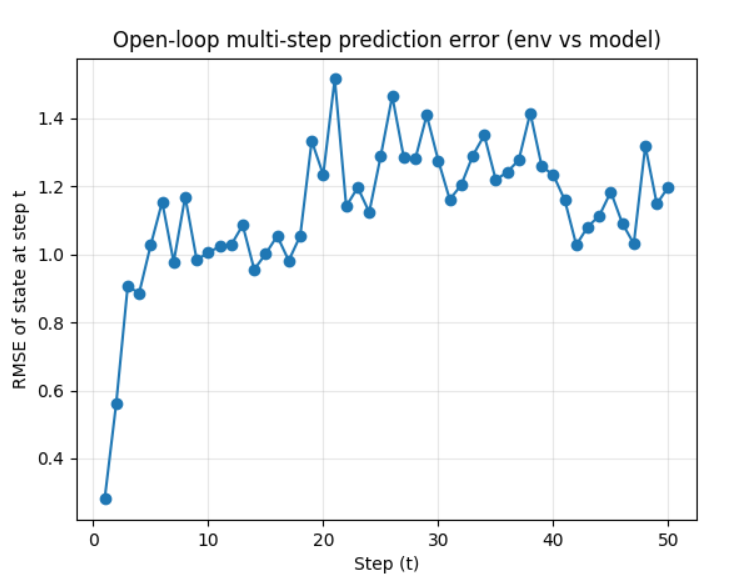

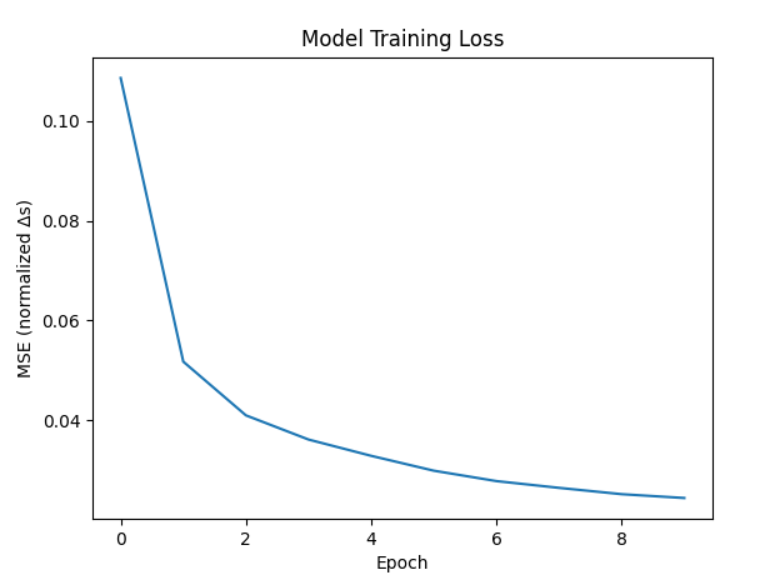

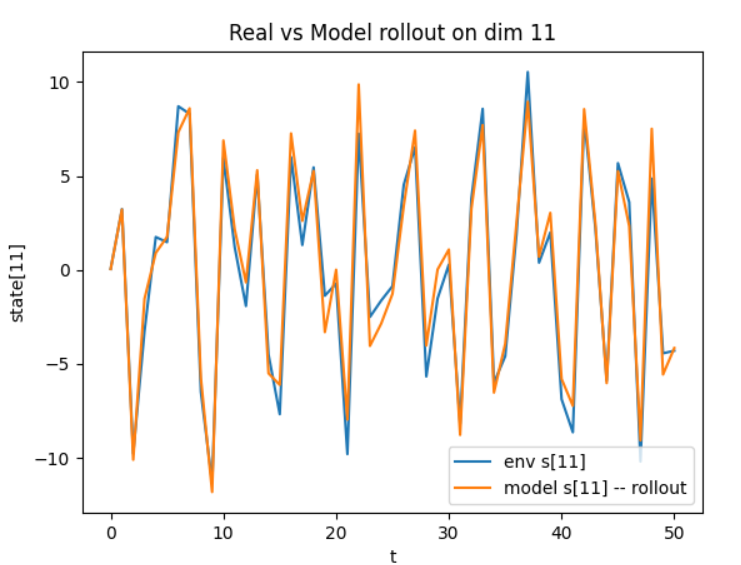


## 9. Answer the questions :

1. How good is your model?
2. Is this training enough for planning, or do we need continual training?
3. How is this system different from the mountain car problem? Why can't we learn this in one episode?
4. Why do we use a runningnormalizer instead of a static normalizer? Think about the nature of the algorithm taught in class.



In a short time, it performs well, but as the number of steps increases, errors accumulate.


Not enough. The current training data is collected randomly and only covers a small portion of the state–action space. Therefore, we need to continue training. Moreover, the set of state spaces visited by the model during planning or control is correlated, so the data sampled and collected during execution is more valuable for training.


In MountainCar, the dynamics are very simple and can be learned quickly, but in HalfCheetah, the state space is enormous, requiring many more episodes to collect a sufficient dataset.


Because the model continuously samples new data for learning, the mean and variance of the dataset keep changing. Therefore, we need to dynamically adjust the normalization algorithm.